In [28]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import normaltest
from statannotations.Annotator import Annotator

### Import SNPGenie results

piN and piS were computed with SNPGenie. 

In [29]:
df_WT= pd.read_csv('../../resources/run_workflow/results_cluster/wild_type/snpgenie_codon_results.csv')
df_KO = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_KO/snpgenie_codon_results.csv')
df_OE = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_overexpression/snpgenie_codon_results.csv')

df_codon = pd.concat([df_WT, df_KO, df_OE])

### Compute pi_S and pi_N per protein 

In [30]:
# per codon measurement

# piS: The mean number of pairwise synonymous differences per synonymous site in this product.
df_codon['piS'] = df_codon['S_diffs']/df_codon['S_sites']

# piN: The mean number of pairwise nonsynonymous differences per nonsynonymous site in this product.
df_codon['piN'] = df_codon['N_diffs']/df_codon['N_sites']

#df_codon['piN/piS'] = df_codon['piN']/df_codon['piS']

In [31]:
df_codon = df_codon[['site', 'codon', 'genotype', 'replicate', 'passage', 'piS', 'piN']]

### Define proteins

In [32]:
# Define proteins
proteins = {
    "1A": (799, 1089),
    "2A": (1092, 1161),
    "2B": (1164, 1587),
    "2C": (1590, 2901),
    "3A": (2904, 3501),
    "3C": (3504, 4422),
    "RdRp": (4425, 6072),
    "VP2": (6267, 7110),
    "VP4": (7113, 7281),
    "VP3": (7284, 8175),
    "VP1": (8175, 8970),
}

protein_order = list(proteins.keys())

In [33]:
df_pis_protein = pd.DataFrame() 

for genotype in ['wild_type', 'dicer_KO', 'dicer_over_expressing']:
    for passage in ["passage_1", "passage_5", "passage_10"]:
        for replicate in ['replicate_d', 'replicate_b', 'replicate_a', 'replicate_e','replicate_c']:
            for protein in proteins.items():
                protein_id = protein[0]
                protein_start = protein[1][0]
                protein_end = protein[1][1]
                protein_length = protein_end - protein_start

                df_temp = df_codon[df_codon['genotype']== genotype]
                df_temp = df_temp[df_temp['passage']==passage]
                df_temp = df_temp[df_temp['replicate']==replicate]
                df_temp = df_temp[df_temp['site'].isin(list(range(protein_start,protein_end+1 )))]

                mean_pis = {
                            'genotype': [genotype], 
                            'passage': passage, 
                            'replicate': replicate,
                            'protein': protein_id,
                            'piN': df_temp['piN'].sum()/protein_length/3, 
                            'piS': df_temp['piS'].sum()/protein_length/3, 
                            'piN-piS': df_temp['piN'].sum()/protein_length - df_temp['piS'].sum()/protein_length/3,
                        }
                df_pis_protein = pd.concat([df_pis_protein, pd.DataFrame(data=mean_pis)])
                

In [34]:
# make dataframe long

df_pis_protein_long = df_pis_protein.drop(["piN-piS"], axis=1)

df_pis_protein_long= pd.wide_to_long(df_pis_protein_long, 
                                      stubnames="pi",
                                      i=["genotype", "passage", "replicate", "protein"],
                                      j="type",
                                      suffix="\D+",)
df_pis_protein_long = df_pis_protein_long.reset_index()

In [35]:
df_pis_protein_long.head()

,genotype,passage,replicate,protein,type,pi
0,wild_type,passage_1,replicate_d,1A,N,0.000009
1,wild_type,passage_1,replicate_d,1A,S,0.000001
2,wild_type,passage_1,replicate_d,2A,N,0.000000
3,wild_type,passage_1,replicate_d,2A,S,0.000000
4,wild_type,passage_1,replicate_d,2B,N,0.000008


In [23]:
df_pis_protein_long.to_csv("df_pis_protein_long.csv")

# plot figure now

In [39]:
df_sns = pd.DataFrame() 

for genotype in ['wild_type', 'dicer_KO', 'dicer_over_expressing']:
    for passage in ["passage_1", "passage_5", "passage_10"]:
        for protein in list(proteins.keys()):
            
            # query relevant rows
            df_temp = df_pis_protein[df_pis_protein['genotype']== genotype]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['protein']==protein]

            for replicate in ['replicate_d', 'replicate_b', 'replicate_a', 'replicate_e','replicate_c']:
                tmp_dict = {
                    "genotype": [genotype], 
                    'passage': passage, 
                    'protein': protein,
                    'replicate': replicate, 
                    'value': df_temp[df_temp['replicate']==replicate]["piN"].values, 
                    'measure': "piN", 
                }
                df_sns = pd.concat([df_sns, pd.DataFrame(data=tmp_dict)])
                
                tmp_dict = {
                    "genotype": [genotype], 
                    'passage': passage, 
                    'protein': protein,
                    'replicate': replicate, 
                    'measure': "piS", 
                    'value': df_temp[df_temp['replicate']==replicate]["piS"].values, 
                }
                df_sns = pd.concat([df_sns, pd.DataFrame(data=tmp_dict)])

In [42]:
df_p_value = pd.DataFrame() 

for genotype in ['wild_type', 'dicer_KO', 'dicer_over_expressing']:
    for passage in ["passage_1", "passage_5", "passage_10"]:
        for protein in list(proteins.keys()) + ["Full_genome"]:
            
            # query relevant rows
            df_temp = df_pis_protein[df_pis_protein['genotype']== genotype]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['protein']==protein]
            
            pi_N = df_temp["piN"].values
            pi_S = df_temp["piS"].values
            
            tmp_dict = {
                "genotype": [genotype], 
                'passage': passage, 
                'protein': protein,
                'mean_piN': np.mean(pi_N), 
                'mean_piS': np.mean(pi_S), 
                'mean_piN-mean_piS': np.mean(pi_N) - np.mean(pi_S), 
                'piN/piS': np.mean(pi_N)/np.mean(pi_S), 
                'sem_piN': stats.sem(pi_N),
                'sem_piS': stats.sem(pi_S),
            }
            df_p_value = pd.concat([df_p_value, pd.DataFrame(data=tmp_dict)])

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lfuhrmann/Library/Pytho

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_57619/862484721.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


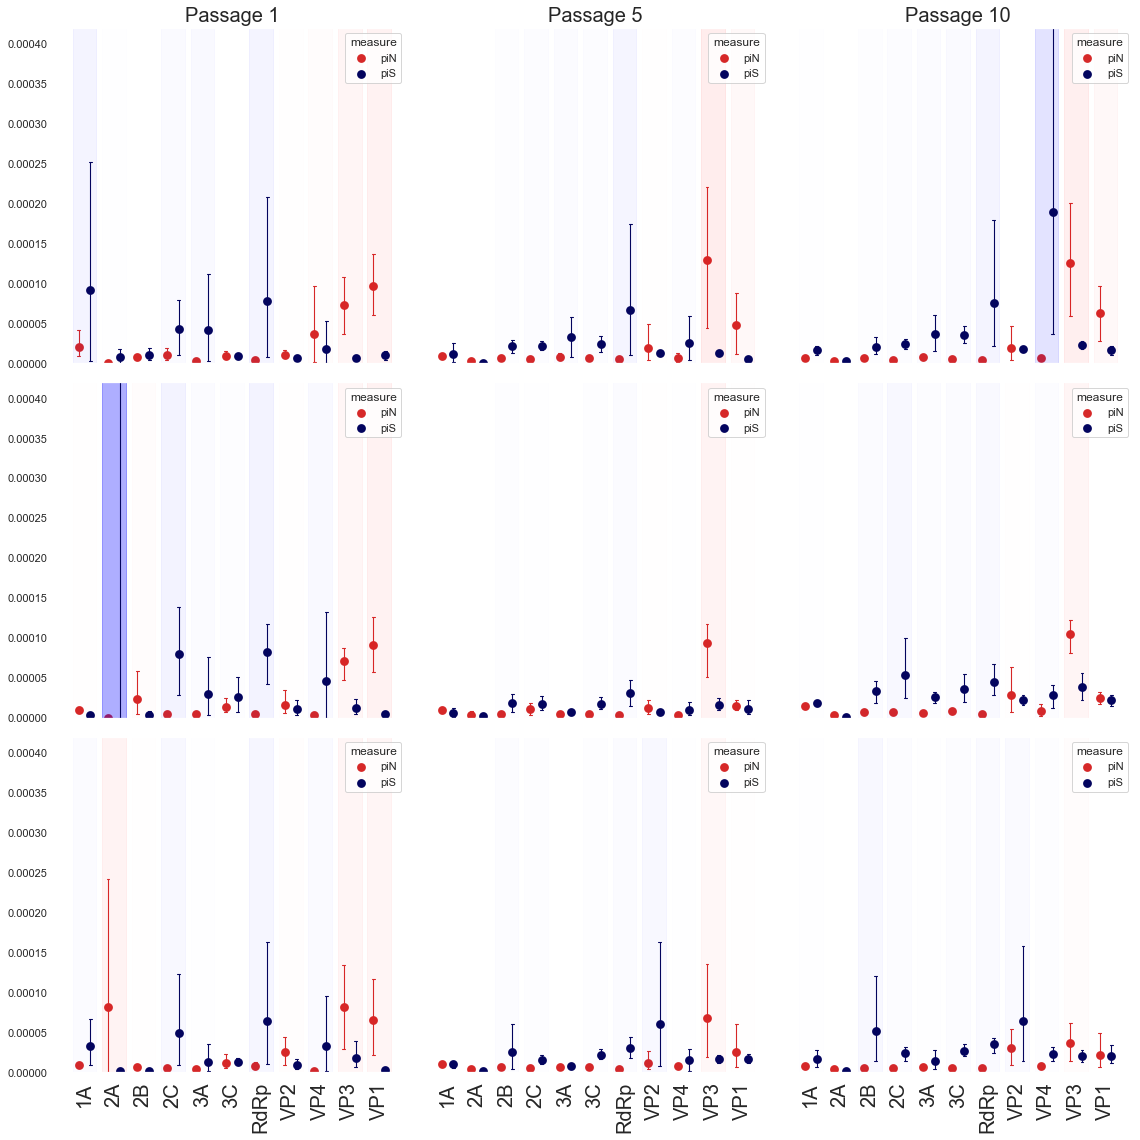

In [43]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(16,16))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

for idx_passage, passage in enumerate(["passage_1", "passage_5", "passage_10"]):
    df_temp = df_sns[df_sns["passage"]==passage]
    for idx_genotype, genotype in enumerate(['wild_type', 'dicer_KO', 'dicer_over_expressing']):
        
        data = df_temp[df_temp["genotype"]==genotype]
        sns.pointplot(
            ax=ax[idx_genotype][idx_passage],
            data=data, 
            markers='o', 
            linestyles='',
            x="protein", 
            y='value', 
            hue ='measure', 
            errorbar=('ci', 95),
            hue_order=["piN", "piS"], 
            errwidth=1.1, 
            capsize=0.1,
            order=protein_order, 
            palette=['#d62828', '#03045e'],
            dodge=0.4, 
        )
        ax[idx_genotype][idx_passage].set_xlabel("")
        ax[idx_genotype][idx_passage].set_ylabel("")


        ax[idx_genotype][idx_passage].set_ylim(0,0.00042)
        
        # shade background to show positive or negative selection
        df_direction_selection = df_p_value[df_p_value["passage"]==passage]
        df_direction_selection = df_direction_selection[df_direction_selection["genotype"]==genotype]
        
        for idx_protein, protein in enumerate(protein_order):  
            piN_minus_piS = df_direction_selection[df_direction_selection["protein"]==protein]["mean_piN-mean_piS"].values[0]
            if piN_minus_piS > 0: # positive selection 
                color = 'red'
                alpha = np.abs(piN_minus_piS)*600
            elif piN_minus_piS < 0: # negative selection 
                color='blue'
                alpha = np.abs(piN_minus_piS)*600
            
            ax[idx_genotype][idx_passage].axvspan(xmin=idx_protein-0.4, xmax=idx_protein+0.4, color=color, alpha=alpha)

ax[2][0].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][1].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][2].tick_params(axis='x', rotation=90, labelsize = 20)

ax[0][0].set_title("Passage 1", fontsize=20)
ax[0][1].set_title("Passage 5", fontsize=20)
ax[0][2].set_title("Passage 10", fontsize=20)

fig.tight_layout()
fig.show()

In [44]:
fig.savefig('./000__Manuscript_figures/Supplement_Figure_6__selection_analysis_revisions.pdf')
fig.savefig('./000__Manuscript_figures/Supplement_Figure_6__selection_analysis_revisions.svg')